# Make PED file for prostate STIX DB

09/24/24, Jake Krol

10/08/24: Index only cancer samples, not normal. Make PED for cancer only

10/14/24: Setup data dirs and copied cancer BEDs for index

## Imports

In [93]:
import pandas as pd
import numpy as np
import os
import itertools
import re
from collections import Counter
import glob
import shutil
import multiprocessing as mp
from multiprocessing import Pool
cpus = int(np.floor((mp.cpu_count()-1) /2))
print(cpus)

35


## ICGC metadata to PED table

In [25]:
os.chdir('/data/jake/gene-fusion/python')

In [26]:
meta = "../data/meta/icgc25k-legacy-data-locations.tsv"
dir_prostate="/data/stix/1kg/cancer_data/prostate/prostate_sort"
#bed_files = [os.path.join(dir_data, f) for f in os.listdir(dir_data)]
bed_files = os.listdir(dir_prostate)
sample_ids = [i.split('.')[0] for i in bed_files]
print(len(bed_files))
print(bed_files[0:5])
print(sample_ids[0:5])

256
['FI45874.excord.bed.gz', 'FI34058.excord.bed.gz', 'FI45517.excord.bed.gz', 'FI30018.excord.bed.gz', 'FI31305.excord.bed.gz']
['FI45874', 'FI34058', 'FI45517', 'FI30018', 'FI31305']


In [27]:
df_icgc = pd.read_csv(meta,sep='\t').dropna(subset='File_ID')
df_icgc.drop(df_icgc.columns[0],axis=1,inplace=True)
df_icgc.columns = [s.lower() for s in df_icgc.columns]
print(df_icgc.shape)
df_icgc.head()

(131770, 22)


/tmp/ipykernel_391042/1259175933.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_icgc = pd.read_csv(meta,sep='\t').dropna(subset='File_ID')


,objectid,file_id,file_name,icgc_donor,icgc_specimen_id,specimen_type,icgc_sample_id,project,study,data_type,...,analysisid,ega_dataset_id,ega_analysis_id,ega_file_id,pcawg,ega_run_id,sftp_location,gdc_id,pdc_id,location
0,413b0e61-fe0b-5c85-b120-407e0050b9a8,FI278747,ba5667da-7688-4931-bdb7-d65f391caf60.embl-dell...,DO35555,SP78676,Primary tumour - solid tissue,SA413338,PBCA-DE,PCAWG,VCF,...,4ef54f75-d71f-48e0-a898-d956490cb18b,NaN,NaN,NaN,whitelist,NaN,PCAWG/dkfz_embl_calls/PCAWG.WGS.icgc.dkfz_embl...,NaN,NaN,SFTP
1,3d30239f-68c4-5954-9e66-99dd9a4ec208,FI665386,d182b67c-c622-11e3-bf01-24c6515278c0.consensus...,DO45239,SP99201,Primary tumour - solid tissue,SA501481,LIRI-JP,PCAWG,VCF,...,6645e983-6f89-434f-80c2-0b96a845ee36,NaN,NaN,NaN,whitelist,NaN,PCAWG/consensus_snv_indel,NaN,NaN,SFTP
2,413a6d50-7ac5-5bdd-8ff6-1bbfc394e42e,FI723646,90347c06c20ad196a3f3c29073bce33f.BD28T_GCCAAT_...,DO222889,SP129239,Primary tumour - solid tissue,SA562210,BTCA-JP,NaN,FASTQ,...,EGAR00001256174,NaN,NaN,NaN,NaN,EGAR00001256174,NaN,NaN,NaN,EGA
3,413bcbe7-cfc8-5368-bdc9-878268030be0,FI725451,68e1c1bb05ee27f7de7b8fa9234fe18c.BD14T_GACCA_L...,DO222467,SP128248,Primary tumour - solid tissue,SA562163,BTCA-JP,NaN,FASTQ,...,EGAR00001255656,NaN,NaN,NaN,NaN,EGAR00001255656,NaN,NaN,NaN,EGA
6,3d389a8b-3eb7-585f-b3d2-1169e079dee3,FI371415,c20cb5c8-a6d0-4150-b72b-3f7e8909d72b.broad-sno...,DO35572,SP78717,Primary tumour - solid tissue,SA413504,PBCA-DE,PCAWG,VCF,...,5e4b8f2f-50cb-4fc1-83a9-21235c29d1ad,NaN,NaN,NaN,whitelist,NaN,PCAWG/broad_calls/PCAWG.WGS.icgc.broad.metadat...,NaN,NaN,SFTP


In [28]:
df_icgc_prostate = df_icgc[df_icgc['file_id'].isin(sample_ids)].reset_index(drop=True)
df_icgc_prostate = df_icgc_prostate[[df_icgc_prostate.columns[1], df_icgc_prostate.columns[0]] + list(df_icgc_prostate.columns[2:])]
print(df_icgc_prostate.shape)
df_icgc_prostate.head()

(256, 22)


,file_id,objectid,file_name,icgc_donor,icgc_specimen_id,specimen_type,icgc_sample_id,project,study,data_type,...,analysisid,ega_dataset_id,ega_analysis_id,ega_file_id,pcawg,ega_run_id,sftp_location,gdc_id,pdc_id,location
0,FI28636,69339f0b-9a4a-5564-8358-70f33386030a,2feefd57350ddcc44473b78a60e14f84.bam,DO51053,SP112792,Normal - blood derived,SA530443,PRAD-CA,PCAWG,BAM,...,46e26175-d23f-47fd-a8ae-0614125a3394,EGAD00001002128,EGAZ00001223176,EGAF00001084795,whitelist,NaN,NaN,NaN,NaN,EGA
1,FI38336,51267957-9b9b-5f7a-b8cf-2c44f7c4697a,7402654effa3a9f010236b0cadd04ce3.bam,DO51954,SP114917,Metastatic tumour - lymph node,SA538889,PRAD-UK,PCAWG,BAM,...,24002e54-f8ba-4848-ba7a-ffcdd572b152,EGAD00001002126,EGAZ00001224905,EGAF00001156874,whitelist,NaN,NaN,NaN,NaN,EGA
2,FI29599,f52c0520-db54-50a5-ae48-6c4b0112ceea,063c8207682a6b9dbaf696adc79b8d21.bam,DO51048,SP112783,Primary tumour - solid tissue,SA530434,PRAD-CA,PCAWG,BAM,...,f56599c3-f644-4f75-b022-181c97d06e1a,EGAD00001002128,EGAZ00001223272,EGAF00001084939,whitelist,NaN,NaN,NaN,NaN,EGA
3,FI24259,0957dd65-e99a-56e0-a1c0-832a21a8e40a,2f942accfbf17679ba2fd8e830adaa78.bam,DO50423,SP111140,Normal - blood derived,SA528983,PRAD-UK,PCAWG,BAM,...,a7b5c33d-237f-4be3-9461-c13f9702035c,EGAD00001002126,EGAZ00001223152,EGAF00001084759,whitelist,NaN,NaN,NaN,NaN,EGA
4,FI10784,fb4faccb-cbcd-5706-bb5a-a8180c7f22bd,2238ab07083b519abceb375f12d7f5f9.bam,DO51067,SP112821,Primary tumour - solid tissue,SA530479,PRAD-CA,PCAWG,BAM,...,e2dd4dfe-980c-4587-bde6-7e9f466d5848,EGAD00001002128,EGAZ00001223260,EGAF00001084921,whitelist,NaN,NaN,NaN,NaN,EGA


In [29]:
df_icgc_prostate = df_icgc_prostate.rename(columns={'file_id': 'sample'})
df_icgc_prostate['alt_file'] = df_icgc_prostate['sample'].apply(lambda x: f'{x}.excord.bed.gz')
alt_file_col = df_icgc_prostate.columns[-1]
df_icgc_prostate.insert(1, alt_file_col, df_icgc_prostate.pop(alt_file_col))
df_icgc_prostate = df_icgc_prostate.sort_values('sample').reset_index(drop=True)
print(df_icgc_prostate.shape)
df_icgc_prostate.head()

(256, 23)


,sample,alt_file,objectid,file_name,icgc_donor,icgc_specimen_id,specimen_type,icgc_sample_id,project,study,...,analysisid,ega_dataset_id,ega_analysis_id,ega_file_id,pcawg,ega_run_id,sftp_location,gdc_id,pdc_id,location
0,FI10013,FI10013.excord.bed.gz,964c2efe-ddec-5269-a042-5edf74c18585,2b678bca6a69d6f0bfb77f3194e4b1b7.bam,DO50427,SP111148,Normal - blood derived,SA528957,PRAD-UK,PCAWG,...,a9eac021-61e1-43aa-901f-cc1e2e960303,EGAD00001002126,EGAZ00001223153,EGAF00001084252,graylist,NaN,NaN,NaN,NaN,EGA
1,FI10092,FI10092.excord.bed.gz,30f2d4c3-0c14-525b-a8ad-ae3b557886e1,89be54787406356f66e0ca61e24121bc.bam,DO51133,SP112952,Normal - blood derived,SA530603,PRAD-CA,PCAWG,...,47a324f6-88d4-4351-bf0f-341c65a1e26c,EGAD00001002128,EGAZ00001223179,EGAF00001084291,whitelist,NaN,NaN,NaN,NaN,EGA
2,FI10093,FI10093.excord.bed.gz,c1b0f8bd-b2ad-5d03-84cd-942971bf193a,3bcb0039e46a4ca217d29b0c77a1ef7e.bam,DO51133,SP112953,Primary tumour - solid tissue,SA530604,PRAD-CA,PCAWG,...,b513c61d-ff71-4ddc-9888-1a406942069e,EGAD00001002128,EGAZ00001225228,EGAF00001162820,whitelist,NaN,NaN,NaN,NaN,EGA
3,FI10765,FI10765.excord.bed.gz,d3f67390-0e59-5f9f-8e26-4389f0ec1857,15b7c47c4cfa038c6a629d4c68a84914.bam,DO51136,SP112958,Normal - blood derived,SA530609,PRAD-CA,PCAWG,...,3d54d365-98ff-4a64-a1bd-99974d9d3730,EGAD00001002128,EGAZ00001225284,EGAF00001162988,whitelist,NaN,NaN,NaN,NaN,EGA
4,FI10766,FI10766.excord.bed.gz,c2ec5d59-5ead-5792-aacb-80078ceff799,7a0090e6dabe350ecc19afb773d430e7.bam,DO51136,SP112959,Primary tumour - solid tissue,SA530610,PRAD-CA,PCAWG,...,b9b072b8-59fd-4d39-a538-03c05b907584,EGAD00001002128,EGAZ00001225318,EGAF00001163090,whitelist,NaN,NaN,NaN,NaN,EGA


In [30]:
df_icgc_prostate['project'].unique()

array(['PRAD-UK', 'PRAD-CA'], dtype=object)

<Axes: xlabel='label'>

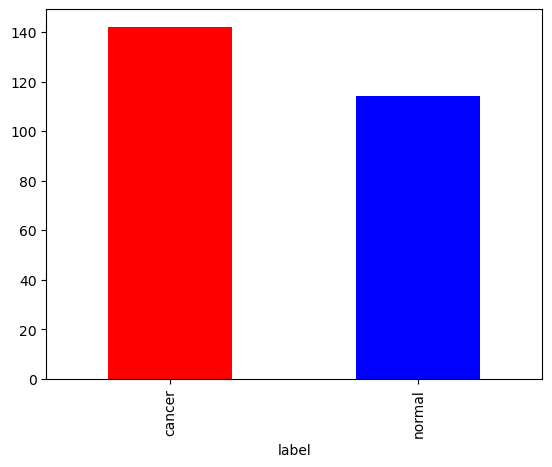

In [31]:
def label_specimen(specimen_str):
    s = specimen_str.lower()
    if re.search('normal', s):
        return 'normal'
    if re.search('cancer|tumour', s):
        return 'cancer'
df_icgc_prostate['label'] = df_icgc_prostate['specimen_type'].apply(lambda x: label_specimen(x))
df_icgc_prostate.groupby(['label'])['label'].value_counts().plot(kind='bar', color=['red', 'blue'])

In [32]:
na_columns = df_icgc_prostate.columns[df_icgc_prostate.isna().any()].tolist()
print(na_columns)

['ega_run_id', 'sftp_location', 'gdc_id', 'pdc_id']


In [33]:
df_icgc_prostate=df_icgc_prostate.drop(columns=na_columns)

Use cancer abbreviations table to map abbreviations to full names

In [34]:
df_cancer_abbrv = pd.read_csv("../data/meta/icgc-cancer-abbreviations.csv")
df_cancer_abbrv[df_cancer_abbrv['abbreviation'].str.match('PRAD')]

,abbreviation,cancer
62,PRAD,Prostate Adenocarcinoma
63,PRAD,Prostate Cancer
64,PRAD,Prostate Cancer
65,PRAD,Prostate Adenocarcinoma
66,PRAD,Prostate Adenocarcinoma


In [35]:
df_icgc_prostate['project'].unique()

array(['PRAD-UK', 'PRAD-CA'], dtype=object)

In [36]:
#df_icgc_prostate['prostate_cancer_sample'] = df_icgc_prostate['project'].apply(lambda x: 1 if x in ['PRAD-UK', 'PRAD-CA'] else 0)
#df_icgc_prostate['prostate_cancer'].unique()

In [95]:
df_icgc_prostate.head()

,sample,alt_file,objectid,file_name,icgc_donor,icgc_specimen_id,specimen_type,icgc_sample_id,project,study,data_type,experimental_strategy,format,analysisid,ega_dataset_id,ega_analysis_id,ega_file_id,pcawg,location,label
0,FI10013,FI10013.excord.bed.gz,964c2efe-ddec-5269-a042-5edf74c18585,2b678bca6a69d6f0bfb77f3194e4b1b7.bam,DO50427,SP111148,Normal - blood derived,SA528957,PRAD-UK,PCAWG,BAM,WGS,BAM,a9eac021-61e1-43aa-901f-cc1e2e960303,EGAD00001002126,EGAZ00001223153,EGAF00001084252,graylist,EGA,normal
1,FI10092,FI10092.excord.bed.gz,30f2d4c3-0c14-525b-a8ad-ae3b557886e1,89be54787406356f66e0ca61e24121bc.bam,DO51133,SP112952,Normal - blood derived,SA530603,PRAD-CA,PCAWG,BAM,WGS,BAM,47a324f6-88d4-4351-bf0f-341c65a1e26c,EGAD00001002128,EGAZ00001223179,EGAF00001084291,whitelist,EGA,normal
2,FI10093,FI10093.excord.bed.gz,c1b0f8bd-b2ad-5d03-84cd-942971bf193a,3bcb0039e46a4ca217d29b0c77a1ef7e.bam,DO51133,SP112953,Primary tumour - solid tissue,SA530604,PRAD-CA,PCAWG,BAM,WGS,BAM,b513c61d-ff71-4ddc-9888-1a406942069e,EGAD00001002128,EGAZ00001225228,EGAF00001162820,whitelist,EGA,cancer
3,FI10765,FI10765.excord.bed.gz,d3f67390-0e59-5f9f-8e26-4389f0ec1857,15b7c47c4cfa038c6a629d4c68a84914.bam,DO51136,SP112958,Normal - blood derived,SA530609,PRAD-CA,PCAWG,BAM,WGS,BAM,3d54d365-98ff-4a64-a1bd-99974d9d3730,EGAD00001002128,EGAZ00001225284,EGAF00001162988,whitelist,EGA,normal
4,FI10766,FI10766.excord.bed.gz,c2ec5d59-5ead-5792-aacb-80078ceff799,7a0090e6dabe350ecc19afb773d430e7.bam,DO51136,SP112959,Primary tumour - solid tissue,SA530610,PRAD-CA,PCAWG,BAM,WGS,BAM,b9b072b8-59fd-4d39-a538-03c05b907584,EGAD00001002128,EGAZ00001225318,EGAF00001163090,whitelist,EGA,cancer


In [38]:
cancer_samples = df_icgc_prostate[df_icgc_prostate['label'] == 'cancer'].reset_index(drop=True)
print(cancer_samples.shape)
cancer_samples.head()

(142, 20)


,sample,alt_file,objectid,file_name,icgc_donor,icgc_specimen_id,specimen_type,icgc_sample_id,project,study,data_type,experimental_strategy,format,analysisid,ega_dataset_id,ega_analysis_id,ega_file_id,pcawg,location,label
0,FI10093,FI10093.excord.bed.gz,c1b0f8bd-b2ad-5d03-84cd-942971bf193a,3bcb0039e46a4ca217d29b0c77a1ef7e.bam,DO51133,SP112953,Primary tumour - solid tissue,SA530604,PRAD-CA,PCAWG,BAM,WGS,BAM,b513c61d-ff71-4ddc-9888-1a406942069e,EGAD00001002128,EGAZ00001225228,EGAF00001162820,whitelist,EGA,cancer
1,FI10766,FI10766.excord.bed.gz,c2ec5d59-5ead-5792-aacb-80078ceff799,7a0090e6dabe350ecc19afb773d430e7.bam,DO51136,SP112959,Primary tumour - solid tissue,SA530610,PRAD-CA,PCAWG,BAM,WGS,BAM,b9b072b8-59fd-4d39-a538-03c05b907584,EGAD00001002128,EGAZ00001225318,EGAF00001163090,whitelist,EGA,cancer
2,FI10784,FI10784.excord.bed.gz,fb4faccb-cbcd-5706-bb5a-a8180c7f22bd,2238ab07083b519abceb375f12d7f5f9.bam,DO51067,SP112821,Primary tumour - solid tissue,SA530479,PRAD-CA,PCAWG,BAM,WGS,BAM,e2dd4dfe-980c-4587-bde6-7e9f466d5848,EGAD00001002128,EGAZ00001223260,EGAF00001084921,whitelist,EGA,cancer
3,FI11979,FI11979.excord.bed.gz,fd22f0c2-d50f-551c-9b11-5496df8a56ef,1c2dad03e47d34118d63bf4cb89d97a4.bam,DO51142,SP112971,Primary tumour - solid tissue,SA530622,PRAD-CA,PCAWG,BAM,WGS,BAM,2b5fe918-e0f8-4c1f-8024-ddcd55557b8d,EGAD00001002128,EGAZ00001225221,EGAF00001162799,whitelist,EGA,cancer
4,FI12251,FI12251.excord.bed.gz,33623629-be74-5373-8457-0e43f805b935,f1c61be3f2beb330e3aa731d8c325ecb.bam,DO51159,SP113005,Primary tumour - solid tissue,SA530656,PRAD-CA,PCAWG,BAM,WGS,BAM,64e6a38c-cf95-4264-b039-99a34dfe3d1a,EGAD00001002128,EGAZ00001225184,EGAF00001160759,whitelist,EGA,cancer


For now, we will include metastatic tumour samples in the prostate cancer index

In [97]:
print(cancer_samples.specimen_type.value_counts())
cancer_samples.head()

specimen_type
Primary tumour - solid tissue                         107
Metastatic tumour - metastasis to distant location     20
Metastatic tumour - lymph node                         15
Name: count, dtype: int64


,sample,alt_file,objectid,file_name,icgc_donor,icgc_specimen_id,specimen_type,icgc_sample_id,project,study,data_type,experimental_strategy,format,analysisid,ega_dataset_id,ega_analysis_id,ega_file_id,pcawg,location,label
0,FI10093,FI10093.excord.bed.gz,c1b0f8bd-b2ad-5d03-84cd-942971bf193a,3bcb0039e46a4ca217d29b0c77a1ef7e.bam,DO51133,SP112953,Primary tumour - solid tissue,SA530604,PRAD-CA,PCAWG,BAM,WGS,BAM,b513c61d-ff71-4ddc-9888-1a406942069e,EGAD00001002128,EGAZ00001225228,EGAF00001162820,whitelist,EGA,cancer
1,FI10766,FI10766.excord.bed.gz,c2ec5d59-5ead-5792-aacb-80078ceff799,7a0090e6dabe350ecc19afb773d430e7.bam,DO51136,SP112959,Primary tumour - solid tissue,SA530610,PRAD-CA,PCAWG,BAM,WGS,BAM,b9b072b8-59fd-4d39-a538-03c05b907584,EGAD00001002128,EGAZ00001225318,EGAF00001163090,whitelist,EGA,cancer
2,FI10784,FI10784.excord.bed.gz,fb4faccb-cbcd-5706-bb5a-a8180c7f22bd,2238ab07083b519abceb375f12d7f5f9.bam,DO51067,SP112821,Primary tumour - solid tissue,SA530479,PRAD-CA,PCAWG,BAM,WGS,BAM,e2dd4dfe-980c-4587-bde6-7e9f466d5848,EGAD00001002128,EGAZ00001223260,EGAF00001084921,whitelist,EGA,cancer
3,FI11979,FI11979.excord.bed.gz,fd22f0c2-d50f-551c-9b11-5496df8a56ef,1c2dad03e47d34118d63bf4cb89d97a4.bam,DO51142,SP112971,Primary tumour - solid tissue,SA530622,PRAD-CA,PCAWG,BAM,WGS,BAM,2b5fe918-e0f8-4c1f-8024-ddcd55557b8d,EGAD00001002128,EGAZ00001225221,EGAF00001162799,whitelist,EGA,cancer
4,FI12251,FI12251.excord.bed.gz,33623629-be74-5373-8457-0e43f805b935,f1c61be3f2beb330e3aa731d8c325ecb.bam,DO51159,SP113005,Primary tumour - solid tissue,SA530656,PRAD-CA,PCAWG,BAM,WGS,BAM,64e6a38c-cf95-4264-b039-99a34dfe3d1a,EGAD00001002128,EGAZ00001225184,EGAF00001160759,whitelist,EGA,cancer


In [40]:
cancer_samples.alt_file.sort_values().to_csv('../data/meta/tumour_samples.txt',sep='\t',header=False,index=False)

In [41]:
#df_icgc_prostate.to_csv('../data/meta/icgc-GRCh37-prostate_cancer.ped',sep='\t',index=False)
cancer_samples.to_csv('../data/meta/icgc-GRCh37-prostate_cancer.ped',sep='\t',index=False)

## Copy cancer beds

In [78]:
dir_prostate="/data/jake/gene-fusion/data/prostate"
dir_prostate_idx = os.path.join(dir_prostate, 'prostate_sort_idx')
dir_prostated_bed = os.path.join(dir_prostate, 'prostate_sort_bed')
for d in [dir_prostate_idx, dir_prostated_bed]:
    if not os.path.exists(d):
        os.mkdir(d)

In [87]:
prefix_src='/data/jake/gene-fusion/data/cancer_data/prostate/prostate_sort'
all_prostate_beds = os.listdir(prefix_src)
all_prostate_beds.sort()
cancer_beds = cancer_samples.alt_file.tolist()
print('cancer:', cancer_beds[0:5])
print('all:',all_prostate_beds[0:5])

cancer: ['FI10093.excord.bed.gz', 'FI10766.excord.bed.gz', 'FI10784.excord.bed.gz', 'FI11979.excord.bed.gz', 'FI12251.excord.bed.gz']
all: ['FI10013.excord.bed.gz', 'FI10092.excord.bed.gz', 'FI10093.excord.bed.gz', 'FI10765.excord.bed.gz', 'FI10766.excord.bed.gz']


In [92]:
def copy_files(bed_file):
    src = os.path.join(prefix_src, bed_file)
    dst = os.path.join(dir_prostated_bed, bed_file)
    shutil.copy(src, dst)

In [94]:
with Pool(processes=cpus) as pool:
    # Map the function `f` to the items in parallel
    pool.map(copy_files, cancer_beds)

In [ ]:
# shards = [os.path.join(prostate_idx,s) for s in os.listdir(giggle_shards)]
# shards.sort()
# shards
# shard_files = {}
# for s in shards:
#     shard_files[s] = os.listdir(os.path.join(s, 'input'))
# list(shard_files.items())[0]


In [77]:
# shard_files

{'/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_0': ['FI45874.excord.bed.gz',
  'FI34058.excord.bed.gz',
  'FI45517.excord.bed.gz',
  'FI30018.excord.bed.gz',
  'FI31305.excord.bed.gz',
  'FI50419.excord.bed.gz',
  'FI34024.excord.bed.gz',
  'FI45994.excord.bed.gz',
  'FI29598.excord.bed.gz',
  'FI19096.excord.bed.gz',
  'FI46852.excord.bed.gz',
  'FI17075.excord.bed.gz',
  'FI23214.excord.bed.gz',
  'FI7773.excord.bed.gz',
  'FI26316.excord.bed.gz',
  'FI496.excord.bed.gz'],
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_1': ['FI23816.excord.bed.gz',
  'FI26317.excord.bed.gz',
  'FI45926.excord.bed.gz',
  'FI34796.excord.bed.gz',
  'FI31306.excord.bed.gz',
  'FI4702.excord.bed.gz',
  'FI46464.excord.bed.gz',
  'FI34076.excord.bed.gz',
  'FI46628.excord.bed.gz',
  'FI48820.excord.bed.gz',
  'FI9270.excord.bed.gz',
  'FI374822.excord.bed.gz',
  'FI34742.excord.bed.gz',
  'FI10784.excord.bed.gz',
  'FI31498.excord.bed.gz'],
 '/data/jake/gene-fusion/data/pro

In [72]:
# 'FI45874.excord.bed.gz' in shard_files['/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_0']

True

In [75]:
# cancer_samples['alt_file'].str.contains('FI45874.excord.bed.gz').sum()

np.int64(0)

In [73]:
# 'FI45874.excord.bed.gz' in cancer_samples['alt_file'].tolist()

False

In [71]:
# # split_dfs = {key: cancer_samples[cancer_samples['alt_file'].isin(value)].reset_index(drop=True) for key, value in shard_files.items()}
# # list(split_dfs.items())[0]
# for key, value in shard_files.items():
#     print(key,value)
#     # print(value, len(value))
#     # alt_file
#     # print(cancer_samples[cancer_samples['alt_file'].isin(value)].reset_index(drop=True))
#     # break

/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_0 ['FI45874.excord.bed.gz', 'FI34058.excord.bed.gz', 'FI45517.excord.bed.gz', 'FI30018.excord.bed.gz', 'FI31305.excord.bed.gz', 'FI50419.excord.bed.gz', 'FI34024.excord.bed.gz', 'FI45994.excord.bed.gz', 'FI29598.excord.bed.gz', 'FI19096.excord.bed.gz', 'FI46852.excord.bed.gz', 'FI17075.excord.bed.gz', 'FI23214.excord.bed.gz', 'FI7773.excord.bed.gz', 'FI26316.excord.bed.gz', 'FI496.excord.bed.gz']
/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_1 ['FI23816.excord.bed.gz', 'FI26317.excord.bed.gz', 'FI45926.excord.bed.gz', 'FI34796.excord.bed.gz', 'FI31306.excord.bed.gz', 'FI4702.excord.bed.gz', 'FI46464.excord.bed.gz', 'FI34076.excord.bed.gz', 'FI46628.excord.bed.gz', 'FI48820.excord.bed.gz', 'FI9270.excord.bed.gz', 'FI374822.excord.bed.gz', 'FI34742.excord.bed.gz', 'FI10784.excord.bed.gz', 'FI31498.excord.bed.gz']
/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_10 ['FI21985.excord.bed.gz', 'FI49944.ex

In [60]:
# for k,v in split_dfs.items():
#     shard = os.path.basename(k)
#     v.to_csv(f'../data/meta/{shard}.ped',sep='\t',index=False)

In [58]:
# os.listdir('../data/meta')

['None.ped',
 'icgc-GRCh37-prostate_cancer.ped',
 'tumour_samples.txt',
 'icgc-cancer-abbreviations.csv',
 'icgc-cancer-abbreviations.txt',
 'icgc25k-legacy-data-locations.tsv']

## Sharded PEDs

In [101]:
shards = [os.path.join(dir_prostate_idx, shard, 'input') for shard in os.listdir(dir_prostate_idx)]
shards

['/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_3/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_0/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_9/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_6/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_7/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_5/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_11/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_10/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_8/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_1/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_12/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_13/input',
 '/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_2/input',
 '/data/jake/gene-fusion/data/prostate/prostate

In [102]:
os.listdir(shards[0])

['FI28637.excord.bed.gz',
 'FI42649.excord.bed.gz',
 'FI3499.excord.bed.gz',
 'FI34041.excord.bed.gz',
 'FI11979.excord.bed.gz',
 'FI49184.excord.bed.gz',
 'FI14824.excord.bed.gz',
 'FI22097.excord.bed.gz',
 'FI46629.excord.bed.gz',
 'FI18299.excord.bed.gz',
 'FI16552.excord.bed.gz']

In [109]:
shard_files = {}
for s in shards:
    shard_files[s] = os.listdir(os.path.join(s))
ex =list(shard_files.items())[0]
print(len(ex[1]), ex)

11 ('/data/jake/gene-fusion/data/prostate/prostate_sort_idx/shard_3/input', ['FI28637.excord.bed.gz', 'FI42649.excord.bed.gz', 'FI3499.excord.bed.gz', 'FI34041.excord.bed.gz', 'FI11979.excord.bed.gz', 'FI49184.excord.bed.gz', 'FI14824.excord.bed.gz', 'FI22097.excord.bed.gz', 'FI46629.excord.bed.gz', 'FI18299.excord.bed.gz', 'FI16552.excord.bed.gz'])


In [112]:
split_dfs = {key: cancer_samples[cancer_samples['alt_file'].isin(value)].reset_index(drop=True) for key, value in shard_files.items()}
for key, value in split_dfs.items():
    shard = os.path.dirname(key)
    ped_path = os.path.join(shard, 'tumour.ped')
    value.to_csv(ped_path,sep='\t',index=False)